Getting the RMSE

In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# --- Load files ---
with open('Data/Model_Predictions_Exhaustive.pkl', 'rb') as f:
    preds_all = pickle.load(f)

with open('Data/Validation_Data.pkl', 'rb') as f:
    data_all = pickle.load(f)


Finding the k value with the minimum validation RMSE

In [2]:
results_summary = {}

for dataset_name, folds in preds_all.items():
    results_summary[dataset_name] = {}
    for fold_name, k_dict in folds.items():
        results_summary[dataset_name][fold_name] = {}
        for k_val, models in k_dict.items():
            for model_name, preds in models.items():
                # get true values
                y_true = data_all[dataset_name][fold_name]['Validation_Dependent_Broken'].to_numpy()
                # get predictions
                y_pred = preds['y_val_broken']
                
                # compute RMSE
                rmse = mean_squared_error(y_true=y_true,y_pred=y_pred)**0.5
                
                # store best k (minimum RMSE) for each model
                if model_name not in results_summary[dataset_name][fold_name]:
                    results_summary[dataset_name][fold_name][model_name] = {"best_k": k_val, "min_rmse": rmse}
                else:
                    if rmse < results_summary[dataset_name][fold_name][model_name]["min_rmse"]:
                        results_summary[dataset_name][fold_name][model_name] = {"best_k": k_val, "min_rmse": rmse}

Save this as a pkl file

In [3]:
# Save results_summary to a pickle file
with open("Data/Best_K_By_Model.pkl", "wb") as f:
    pickle.dump(results_summary, f)

print("Saved results_summary to Data/Best_K_By_Model.pkl")

Saved results_summary to Data/Best_K_By_Model.pkl


Open the Data

In [21]:
import pickle

# Load feature rankings
with open('Data/Feature_Ranking_By_MRMR_Reordered.pkl', 'rb') as f:
    Feature_Ranking_By_MRMR = pickle.load(f)

# Load feature rankings
with open('Data/Best_K_By_Model.pkl', 'rb') as f:
    Best_K_By_Model = pickle.load(f)

with open('Data/Validation_Data.pkl', 'rb') as f:
    data_all = pickle.load(f)


Training on the full Datasets

In [5]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.base import clone
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

import lightgbm as lgb
import xgboost as xgb

# Define your models (as given)
regression_models = {
    "Linear Regression": LinearRegression(),
    "KNN Regression": KNeighborsRegressor(),
    "SVM Regression": SVR(),
    "Random Forest Regression": RandomForestRegressor(random_state=42),
    "AdaBoost Regression": AdaBoostRegressor(random_state=42),
    "MLP Regression": MLPRegressor(random_state=42),
    "Decision Tree Regression": DecisionTreeRegressor(random_state=42),
    "Extremely Randomized Trees Regression": ExtraTreesRegressor(random_state=42),
    "Gradient Boosting Regression": GradientBoostingRegressor(random_state=42),
    "LightGBM Regression": lgb.LGBMRegressor(random_state=42, verbose=-1),
    "XGBoost Regression": xgb.XGBRegressor(random_state=42)
}

def compute_avg_rmse_across_folds(data_all: dict, models: dict) -> pd.DataFrame:
    """
    For each dataset in `data_all`, train each model on every fold's Training_Full,
    evaluate RMSE on Testing_Full, then average RMSE across folds.

    Expected structure:
    data_all[dataset][fold] has keys:
        'Training_Independent_Full', 'Training_Dependent_Full',
        'Testing_Independent_Full',  'Testing_Dependent_Full'

    Returns:
        pd.DataFrame with columns ['Dataset', 'Model', 'Avg_RMSE']
    """
    rows = []

    for dataset_name, folds in data_all.items():
        # Prepare container for RMSEs per model
        rmse_per_model = {model_name: [] for model_name in models.keys()}

        # Iterate folds (only those named like 'foldX')
        for fold_name, parts in folds.items():
            if not isinstance(parts, dict):
                continue
            required_keys = {
                'Training_Independent_Full',
                'Training_Dependent_Full',
                'Testing_Independent_Full',
                'Testing_Dependent_Full'
            }
            if not required_keys.issubset(parts.keys()):
                continue  # skip malformed fold

            X_train = parts['Training_Independent_Full']
            y_train = parts['Training_Dependent_Full']
            X_test  = parts['Testing_Independent_Full']
            y_test  = parts['Testing_Dependent_Full']

            # Ensure array-like targets
            y_train_arr = np.asarray(y_train).ravel()
            y_test_arr  = np.asarray(y_test).ravel()

            for model_name, model in models.items():
                est = clone(model)  # fresh instance per fold
                est.fit(X_train, y_train_arr)
                y_pred = est.predict(X_test)
                rmse = float(np.sqrt(mean_squared_error(y_test_arr, y_pred)))
                rmse_per_model[model_name].append(rmse)

        # After all folds, compute average RMSE per model
        for model_name, rmses in rmse_per_model.items():
            if rmses:  # only include models that ran on at least one fold
                rows.append({
                    "Dataset": dataset_name,
                    "Model": model_name,
                    "Avg_RMSE": float(np.mean(rmses))
                })

    df = pd.DataFrame(rows)
    return df

# --- Run and get the summary DataFrame ---
df_avg_rmse = compute_avg_rmse_across_folds(data_all, regression_models)
df_avg_rmse

c:\Users\25644574\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\25644574\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\25644574\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\25644574\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached 

,Dataset,Model,Avg_RMSE
0,Airfoil_Self_Noise,Linear Regression,2.768268
1,Airfoil_Self_Noise,KNN Regression,2.651513
2,Airfoil_Self_Noise,SVM Regression,2.973089
3,Airfoil_Self_Noise,Random Forest Regression,1.832459
4,Airfoil_Self_Noise,AdaBoost Regression,3.112117
...,...,...,...
204,Wine_Quality,Decision Tree Regression,0.826328
205,Wine_Quality,Extremely Randomized Trees Regression,0.585576
206,Wine_Quality,Gradient Boosting Regression,0.677514
207,Wine_Quality,LightGBM Regression,0.633525


Training on the best K datasets

In [6]:
import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.metrics import mean_squared_error

# Assumes these are already defined/imported:
# regression_models, data_all, Feature_Ranking_By_MRMR, Best_K_By_Model

def avg_rmse_with_bestk(data_all, feature_ranking_by_mrmr, best_k_by_model, models):
    """
    For each dataset, fold, and model:
      - read best_k from best_k_by_model[dataset][fold][model]['best_k']
      - take the top-k MRMR features from feature_ranking_by_mrmr[dataset][fold][k]
      - train on Training_Independent_Full/Training_Dependent_Full (restricted to those features)
      - evaluate RMSE on Testing_Independent_Full/Testing_Dependent_Full
    Return a DataFrame with columns ['Dataset', 'Model', 'Avg_RMSE'] averaged across folds.
    """
    rows = []

    for dataset_name, folds in data_all.items():
        # collect RMSEs per model across folds
        rmse_per_model = {m: [] for m in models.keys()}

        for fold_name, parts in folds.items():
            # guard: require the full splits
            req = {'Training_Independent_Full','Training_Dependent_Full',
                   'Testing_Independent_Full','Testing_Dependent_Full'}
            if not isinstance(parts, dict) or not req.issubset(parts.keys()):
                continue

            # pull X/y
            X_train_full = parts['Training_Independent_Full']
            y_train_full = np.asarray(parts['Training_Dependent_Full']).ravel()
            X_test_full  = parts['Testing_Independent_Full']
            y_test_full  = np.asarray(parts['Testing_Dependent_Full']).ravel()

            for model_name, base_est in models.items():
                # get best k for this dataset/fold/model
                try:
                    k = best_k_by_model[dataset_name][fold_name][model_name]['best_k']
                except KeyError:
                    # skip if no best_k available
                    continue

                # get the top-k feature list for this dataset/fold
                try:
                    topk_features = feature_ranking_by_mrmr[dataset_name][fold_name][k]
                except KeyError:
                    # if ranking missing, skip
                    continue

                # # some safety: keep only features that exist in X
                # feat = [f for f in topk_features if f in X_train_full.columns]
                # if len(feat) == 0:
                #     continue

                Xtr = X_train_full[topk_features]
                Xte = X_test_full[topk_features]

                est = clone(base_est)
                est.fit(Xtr, y_train_full)
                y_pred = est.predict(Xte)
                rmse = float(np.sqrt(mean_squared_error(y_test_full, y_pred)))
                rmse_per_model[model_name].append(rmse)

        # aggregate across folds for this dataset
        for model_name, rmses in rmse_per_model.items():
            if rmses:
                rows.append({
                    "Dataset": dataset_name,
                    "Model": model_name,
                    "Avg_RMSE": float(np.mean(rmses))
                })

    df = pd.DataFrame(rows)
    return df

# ---- run it ----
df_bestk_avg_rmse = avg_rmse_with_bestk(
    data_all,
    Feature_Ranking_By_MRMR,
    Best_K_By_Model,
    regression_models
)

df_bestk_avg_rmse


c:\Users\25644574\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\25644574\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\25644574\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\25644574\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached 

,Dataset,Model,Avg_RMSE
0,Airfoil_Self_Noise,Linear Regression,2.787071
1,Airfoil_Self_Noise,KNN Regression,2.531926
2,Airfoil_Self_Noise,SVM Regression,2.903657
3,Airfoil_Self_Noise,Random Forest Regression,1.833946
4,Airfoil_Self_Noise,AdaBoost Regression,3.133999
...,...,...,...
204,Wine_Quality,Decision Tree Regression,0.831660
205,Wine_Quality,Extremely Randomized Trees Regression,0.586325
206,Wine_Quality,Gradient Boosting Regression,0.678544
207,Wine_Quality,LightGBM Regression,0.635341


Now lets us combine the two

In [7]:
# Merge on Dataset + Model
df_combined = pd.merge(
    df_avg_rmse,
    df_bestk_avg_rmse,
    on=["Dataset", "Model"],
    how="inner",
    suffixes=("_Full", "_BestK")
)

df_combined

,Dataset,Model,Avg_RMSE_Full,Avg_RMSE_BestK
0,Airfoil_Self_Noise,Linear Regression,2.768268,2.787071
1,Airfoil_Self_Noise,KNN Regression,2.651513,2.531926
2,Airfoil_Self_Noise,SVM Regression,2.973089,2.903657
3,Airfoil_Self_Noise,Random Forest Regression,1.832459,1.833946
4,Airfoil_Self_Noise,AdaBoost Regression,3.112117,3.133999
...,...,...,...,...
204,Wine_Quality,Decision Tree Regression,0.826328,0.831660
205,Wine_Quality,Extremely Randomized Trees Regression,0.585576,0.586325
206,Wine_Quality,Gradient Boosting Regression,0.677514,0.678544
207,Wine_Quality,LightGBM Regression,0.633525,0.635341


Saving the result

In [8]:
import pickle

with open("Data/df_combined.pkl", "wb") as f:
    pickle.dump(df_combined, f)

print("Saved df_combined to df_combined.pkl")


Saved df_combined to df_combined.pkl


Plotting the results

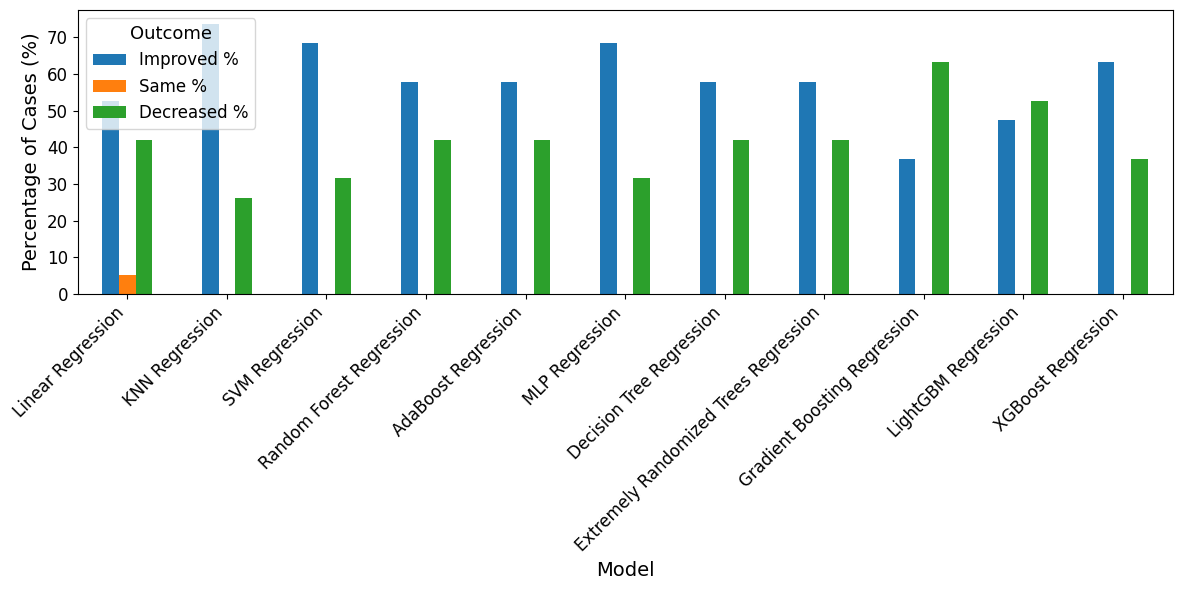

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Collect stats for each model
model_stats = []
for model in df_combined["Model"].unique():
    df_model = df_combined[df_combined["Model"] == model]
    improved = (df_model["Avg_RMSE_BestK"] < df_model["Avg_RMSE_Full"]).sum()
    same     = (df_model["Avg_RMSE_BestK"] == df_model["Avg_RMSE_Full"]).sum()
    decreased = (df_model["Avg_RMSE_BestK"] > df_model["Avg_RMSE_Full"]).sum()
    total = len(df_model)
    if total > 0:
        model_stats.append({
            "Model": model,
            "Improved %": 100 * improved / total,
            "Same %": 100 * same / total,
            "Decreased %": 100 * decreased / total
        })

# Convert to DataFrame for plotting
df_stats = pd.DataFrame(model_stats).set_index("Model")

# Plot grouped bar chart
ax = df_stats.plot(kind="bar", figsize=(12,6))

# Formatting
ax.set_ylabel("Percentage of Cases (%)", fontsize=14)
ax.set_xlabel("Model", fontsize=14)
ax.set_title("")  # remove title
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Outcome", fontsize=12, title_fontsize=13)
plt.tight_layout()
# Save the figure as PDF (before plt.show())
plt.savefig("Improvements_Exhaustive_FS.pdf", format="pdf", bbox_inches="tight")
plt.show()


Comparing performance for statistical significance

In [10]:
import numpy as np
from scipy.stats import wilcoxon

# Flatten across all datasets/models
diffs = df_combined['Avg_RMSE_Full'] - df_combined['Avg_RMSE_BestK']  # arrays of shape (220,)
stat, p = wilcoxon(diffs, alternative="greater")

print("Global Wilcoxon statistic:", stat, "p-value:", p)


Global Wilcoxon statistic: 13159.0 p-value: 0.004193551347563147


Comparison across datasets

In [11]:
# Group by dataset
results = []

for dataset, df_group in df_combined.groupby("Dataset"):
    improved = (df_group["Avg_RMSE_BestK"] < df_group["Avg_RMSE_Full"]).all()
    decreased = (df_group["Avg_RMSE_BestK"] > df_group["Avg_RMSE_Full"]).all()
    
    if improved or decreased:
        results.append({
            "Dataset": dataset,
            "All Improved": improved,
            "All Decreased": decreased
        })

df_results = pd.DataFrame(results)

df_results


""
